In [1]:
import warnings
warnings.filterwarnings("ignore")

#### Installing Necessary Libraries

In [2]:
# !pip install pandas
# !pip install networkx
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install vaderSentiment
# !pip install seaborn
# !pip install bertopic
# !pip install python-louvain
# !python -m spacy download en_core_web_sm --user
# !pip install -U spacy

#### Necessary Imports

In [2]:
import spacy
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
from umap import UMAP
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
import community.community_louvain as community_louvain
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Load Spacy NLP model
nlp = spacy.load("en_core_web_sm")

#### Loading and Preprocessing data

In [3]:
with open("InvestmentClub_submissions_refined.json", "r", encoding="utf-8") as file:
    data1 = json.load(file)

with open("InvestmentClub_comments_refined.json", "r", encoding="utf-8") as file:
    data2 = json.load(file)

df_sub = pd.DataFrame(data1)
df_com= pd.DataFrame(data2)

df_com["unique_id"] = df_com["parent_id"].str.replace("t3_", "").str.replace("t1_", "")
df_com["created_utc"] = pd.to_datetime(df_com["created_utc"], unit="s")
df_sub["created_utc"] = pd.to_datetime(df_sub["created_utc"], unit="s")

In [4]:
print("Length of Submissions Dataset",len(df_sub))
print("Length of Comments Dataset",len(df_com))

Length of Submissions Dataset 18971
Length of Comments Dataset 22863


#### Custom Data Overview: Inspecting Reddit Submissions and Comments

In [5]:
def custom_info(df):
    print(f"<class 'pandas.core.frame.DataFrame'>")
    print(f"RangeIndex: {df.shape[0]} entries, 0 to {df.shape[0] - 1}")
    print(f"Data columns (total {df.shape[1]} columns):")
    print(f"{' #':<4} {'Column':<35} {'Null Count':<20} {'Dtype'}")
    print("-" * 80)

    for i, col in enumerate(df.columns):
        non_null_count = df[col].isna().sum()
        dtype = df[col].dtype
        print(f"{i:<4} {col:<35} {non_null_count:<20} {dtype}")

    print(f"\ndtypes: {', '.join([f'{t}({list(df.dtypes).count(t)})' for t in df.dtypes.unique()])}")
    print(f"memory usage: {df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")

In [6]:
custom_info(df_sub)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18971 entries, 0 to 18970
Data columns (total 128 columns):
 #   Column                              Null Count           Dtype
--------------------------------------------------------------------------------
0    downs                               0                    int64
1    link_flair_text                     9647                 object
2    distinguished                       18873                object
3    media                               16298                object
4    url                                 31                   object
5    link_flair_css_class                9647                 object
6    id                                  0                    object
7    edited                              0                    object
8    num_reports                         18971                object
9    created_utc                         0                    datetime64[ns]
10   banned_by                           189

In [7]:
df_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22863 entries, 0 to 22862
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   controversiality                 22863 non-null  int64         
 1   downs                            22863 non-null  int64         
 2   id                               22863 non-null  object        
 3   score                            22863 non-null  int64         
 4   score_hidden                     22863 non-null  bool          
 5   name                             22863 non-null  object        
 6   edited                           22863 non-null  object        
 7   body                             22863 non-null  object        
 8   subreddit_id                     22863 non-null  object        
 9   created_utc                      22863 non-null  datetime64[ns]
 10  gilded                           22863 non-null  int64    

#### Merging Posts and Comments for Network Analysis

In [8]:
# Columns to retain from Posts Dataset
posts_columns = [
    'id',
    'author',
    'title',
    'created_utc',
    'score',
    'num_comments',
]

# Columns to retain from Comments Dataset
comments_columns = [
    'id',
    'author',
    'unique_id',
    'parent_id',
    'body',
    'created_utc',
    'score',
    'link_id',
    'ups',
    'downs'
]

df_sub = df_sub[posts_columns]
df_com = df_com[comments_columns]

new_df = df_com[df_com['unique_id'].isin(df_sub['id'])]
merged_data = new_df.merge(df_sub, left_on='unique_id', right_on='id', how='inner', suffixes=('_comment', '_post'))

# Combine title and body columns into a single text column
merged_data['text'] = merged_data['title'] + ' ' + merged_data['body']

# merged_data = merged_data.sample(n=500, random_state=42)

In [9]:
merged_data.columns

Index(['id_comment', 'author_comment', 'unique_id', 'parent_id', 'body',
       'created_utc_comment', 'score_comment', 'link_id', 'ups', 'downs',
       'id_post', 'author_post', 'title', 'created_utc_post', 'score_post',
       'num_comments', 'text'],
      dtype='object')

In [10]:
merged_data.shape

(14042, 17)

In [11]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14042 entries, 0 to 14041
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_comment           14042 non-null  object        
 1   author_comment       14042 non-null  object        
 2   unique_id            14042 non-null  object        
 3   parent_id            14042 non-null  object        
 4   body                 14042 non-null  object        
 5   created_utc_comment  14042 non-null  datetime64[ns]
 6   score_comment        14042 non-null  int64         
 7   link_id              14042 non-null  object        
 8   ups                  14042 non-null  int64         
 9   downs                14042 non-null  int64         
 10  id_post              14042 non-null  object        
 11  author_post          14042 non-null  object        
 12  title                14042 non-null  object        
 13  created_utc_post     14042 non-

In [12]:
# Get the top 5 most active users based on interactions
top_users = merged_data["author_comment"].value_counts().head(5)
top_5_users = top_users.index.tolist()

# Filter dataset for interactions involving the top 5 users
filtered_df = merged_data[merged_data['author_comment'].isin(top_5_users)]

In [13]:
# Initialize directed graph
G_top_5_users = nx.DiGraph()

# Add edges from filtered dataset
for _, row in filtered_df.iterrows():
    parent = row['author_comment']
    child = row['unique_id']
    if pd.notna(parent) and pd.notna(child):
        G_top_5_users.add_edge(parent, child)

In [14]:
# Calculate centrality metrics
degree_centrality = nx.degree_centrality(G_top_5_users)
betweenness_centrality = nx.betweenness_centrality(G_top_5_users)
closeness_centrality = nx.closeness_centrality(G_top_5_users)

def get_node_positions(graph):
    return nx.spring_layout(graph, seed=42, k=0.3)

# Get positions for top 5 users
pos_top_5_users = get_node_positions(G_top_5_users)

def extract_plot_data(graph, pos):
    node_x, node_y, node_labels = [], [], []
    for node, (x, y) in pos.items():
        node_x.append(x)
        node_y.append(y)
        node_labels.append(node)

    edge_x, edge_y = [], []
    for edge in graph.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    return node_x, node_y, node_labels, edge_x, edge_y

# Extract node and edge positions
node_x, node_y, node_labels, edge_x, edge_y = extract_plot_data(G_top_5_users, pos_top_5_users)

# Scale node sizes dynamically
node_sizes = [degree_centrality[node] * 300 for node in G_top_5_users.nodes()]

# Normalize degree centrality values for coloring
min_dc, max_dc = min(degree_centrality.values()), max(degree_centrality.values())

def create_degree_centrality_plot(node_sizes):

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="gray"),
        hoverinfo="none",
        mode="lines"
    ))
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        marker=dict(
            size=node_sizes,
            color=[degree_centrality[node] for node in G_top_5_users.nodes()],
            colorscale="YlOrRd",
            colorbar=dict(title="Degree Centrality"),
            opacity=0.8
        ),
        text=node_labels,
        textposition="top center",
        hoverinfo="text"
    ))
    fig.update_layout(
        title="Degree Centrality of Top 5 Users",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    )
    return fig

def create_btwn_closns_centrality_plot(title, centrality_values, color_scale):
    """Creates a Plotly graph for betweenness or closeness centrality with fixed node sizes."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="gray"),
        hoverinfo="none",
        mode="lines"
    ))
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        marker=dict(
            size=12,
            color=[centrality_values[node] for node in G_top_5_users.nodes()],
            colorscale=color_scale,
            colorbar=dict(title=title),
            opacity=0.8
        ),
        text=node_labels,
        textposition="top center",
        hoverinfo="text"
    ))
    fig.update_layout(
        title=title,
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    )
    return fig

### Closeness Centrality for the Top 5 Most Active Users

Closeness Centrality for these top 5 users means that they have the shortest average distance to all other users in the subreddit community. They are positioned in the network in such a way that they can interact with or "reach" other users quickly (i.e., fewer steps are needed to connect to other users)

In [15]:
# Create plots for each centrality measure
fig_closeness = create_btwn_closns_centrality_plot("Closeness Centrality of Top 5 Users", closeness_centrality, "Blues")

# Show plots
fig_closeness.show()

### Betweeness Centrality Analysis of the Top 5 Users

Betweenness Centrality for these top 5 users measures how often they act as bridges between other users in the subreddit community. These users facilitate interactions by connecting different parts of the network, meaning they play a crucial role in information flow and community cohesion.

In [16]:
# Create plots for each centrality measure
fig_betweenness = create_btwn_closns_centrality_plot("Betweenness Centrality of Top 5 Users", betweenness_centrality, "Blues")

# Show plots
fig_betweenness.show()

### Degree Centrality

Degree Centrality for these top 5 users reflects the number of direct connections they have within the subreddit community. Users with higher degree centrality appear larger in the visualization, indicating their greater number of interactions. Additionally, their colors range from yellow to red, where deeper red hues correspond to higher degree centrality values. This visually highlights the most influential users in terms of direct engagement with others.

In [17]:
# Create plots for each centrality measure
fig_degree = create_degree_centrality_plot(node_sizes)

# Show plots
fig_degree.show()

### Directed Interaction Graphs for the Top 5 Most Active Users

In [18]:
for user in top_5_users:

    # Filter dataset for interactions involving this user
    user_df = merged_data[(merged_data["author_comment"] == user) | (merged_data["unique_id"] == user)]

    # Create a directed graph
    G_user = nx.DiGraph()

    # Add edges from the filtered dataset
    for _, row in user_df.iterrows():
        parent = row["author_comment"]
        child = row["unique_id"]
        if pd.notna(parent) and pd.notna(child):
            G_user.add_edge(parent, child)

    # Use a spring layout for better visualization
    pos_user = get_node_positions(G_user)


    # Extract node positions
    node_x, node_y, node_labels = [], [], []
    for node, (x, y) in pos_user.items():
        node_x.append(x)
        node_y.append(y)
        node_labels.append(node)

    # Extract edge positions
    edge_x, edge_y = [], []
    for edge in G_user.edges():
        x0, y0 = pos_user[edge[0]]
        x1, y1 = pos_user[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    # Create a directed graph visualization using Plotly
    fig_user = go.Figure()

    # Add edges (lines)
    fig_user.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color="gray"),
        hoverinfo="none",
        mode="lines"
    ))

    # Add nodes with labels
    fig_user.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        marker=dict(size=12, color=["red" if node == user else "blue" for node in node_labels], opacity=0.8),
        text=node_labels,
        textposition="top center",
        hoverinfo="text"
    ))


    fig_user.update_layout(
        title=f"Directed Interaction Graph for {user}",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    )


    fig_user.show()

### Topic Modelling

In [20]:
# Custom stopword list
with open("stopwordFile.txt", "r") as f:
    custom_stopwords = set(f.read().splitlines())

# Preprocess Text (remove stopwords, lemmatize, clean)
def preprocess(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.lemma_ not in custom_stopwords
              and not token.is_stop and not token.is_punct]
    return " ".join(tokens)

merged_data['cleaned_text'] = merged_data['text'].fillna('')
merged_data["cleaned_text"] = merged_data["cleaned_text"].apply(preprocess)

In [21]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words=list(custom_stopwords), ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(merged_data["cleaned_text"])

# UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=20, n_components=10, min_dist=0.0, metric="cosine")
X_umap = umap_model.fit_transform(X_tfidf.toarray())

# LDA Topic Modeling
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X_tfidf)

# Extracting top words for each topic
words = vectorizer.get_feature_names_out()
topics_info = []
for i, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[-10:][::-1]
    top_words = [words[j] for j in top_words_indices]

    topic_label = f"Topic {i+1}"

    topic_name = ", ".join(top_words)

    # Create the count (frequency of each word in the topic)
    word_count = [topic[j] for j in top_words_indices]

    # Append the topic information to the list
    topics_info.append([topic_label, topic_name, word_count])

# Convert topics info into DataFrame
topics_df = pd.DataFrame(topics_info, columns=["topic_label", "topic_name", "count"])

# Assign topics to the merged_data DataFrame
topic_assignments = lda.transform(X_tfidf)
merged_data["topic"] = topic_assignments.argmax(axis=1)

# Count the number of rows assigned to each topic
topic_counts = merged_data['topic'].value_counts().reset_index()
topic_counts.columns = ['topic_label', 'row_count']

# Convert topic_label to string to match with topics_df
topic_counts['topic_label'] = topic_counts['topic_label'].apply(lambda x: f"Topic {x + 1}")

topics_df = topics_df.merge(topic_counts, on='topic_label', how='left')
merged_data['topic'] = merged_data['topic'].astype(str)
merged_data = merged_data.merge(topics_df[['topic_label', 'topic_name']], left_on='topic', right_on='topic_label', how='left')

sorted_topics_df = topics_df[["topic_label", "topic_name", "row_count"]].sort_values(by="row_count", ascending=False)
sorted_topics_df

topic_label                                         topic_name  row_count
5     Topic 6  market, company, year, buy, money, time, like,...       4398
4     Topic 5  investment, buy, stock, invest, term, portfoli...       1585
2     Topic 3  book, stock, invest, read, com, spam, market, ...       1393
7     Topic 8  delete, buy, com, https, investment, remove, t...       1297
9    Topic 10  cryptocurrencie, subreddit, stock, subreddit a...       1061
1     Topic 2  gold, tesla, musk, elon, remove, elon musk, in...       1038
6     Topic 7  stock portfolio, portfolio, investing guru, gu...        944
0     Topic 1  post, beginner, remove, post comment, comment,...        905
8     Topic 9  buffett, warren, warren buffett, stock, delete...        821
3     Topic 4  quality, post, low quality, improve, quality p...        600

### Top Topics by Frequency

In [22]:
# Create interactive bar chart
fig = px.bar(
    sorted_topics_df,
    x="topic_label",
    y="row_count",
    text="row_count",
    hover_data=["topic_name"],
    labels={"topic_label": "Topic", "row_count": "Number of Mentions"},
    title="Topic Mentions in Dataset"
)

fig.update_traces(textposition="outside")
fig.update_layout(xaxis_tickangle=-45)

fig.show()

## Community Analysis

In [23]:
# Function to build graph for each topic
def build_graph(df, topic):
    G = nx.Graph()
    topic_data = df[df["topic"] == topic]

    for _, row in topic_data.iterrows():
        user = row["author_comment"]
        reply_to = row["unique_id"]

        G.add_node(user)

        if pd.notna(reply_to):
            G.add_node(reply_to)
            G.add_edge(user, reply_to)

    return G

def plot_community_graph(G, topic):
    if G.number_of_nodes() == 0:
        print(f"Skipping {topic} - No interactions")
        return

    partition = community_louvain.best_partition(G)
    pos = nx.spring_layout(G, seed=42)
    node_colors = [partition[node] for node in G.nodes()]

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode="lines", line=dict(width=0.5, color="gray"), hoverinfo="none"))
    node_x, node_y = zip(*[pos[node] for node in G.nodes()])
    node_text = list(G.nodes())

    fig.add_trace(go.Scatter(
        x=node_x, y=node_y, mode="markers",
        marker=dict(size=10, color=node_colors, colorscale="Viridis", showscale=True),
        text=node_text, hoverinfo="text"
    ))

    fig.update_layout(
        title=f"Community Graph for Topic: {topic}",
        showlegend=False, hovermode="closest",
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
    fig.show()

# Generate Graphs for Each Topic
unique_topics = merged_data["topic"].dropna().unique()
for topic in unique_topics:
    G = build_graph(merged_data, topic)
    plot_community_graph(G, topic)

In [24]:
# topics_df.to_csv("topics_names.csv")

### Community Talking about Warren Buffet

In [25]:
# Filter relevant comments
rel_comments = merged_data["cleaned_text"].str.contains(r"\b(warren|buffet|warren buffet)\b", case=False, na=False)

# Count occurrences by year
merged_data["year"] = pd.to_datetime(merged_data["created_utc_comment"], unit="s").dt.year
com_count = merged_data[rel_comments].groupby("year").size().reset_index(name="count")

fig = px.line(com_count, x="year", y="count", markers=True, title="Mentions of Warren Buffet Over Time")
fig.show()

### Rich-Club Coefficient During Peak Years of Discussion

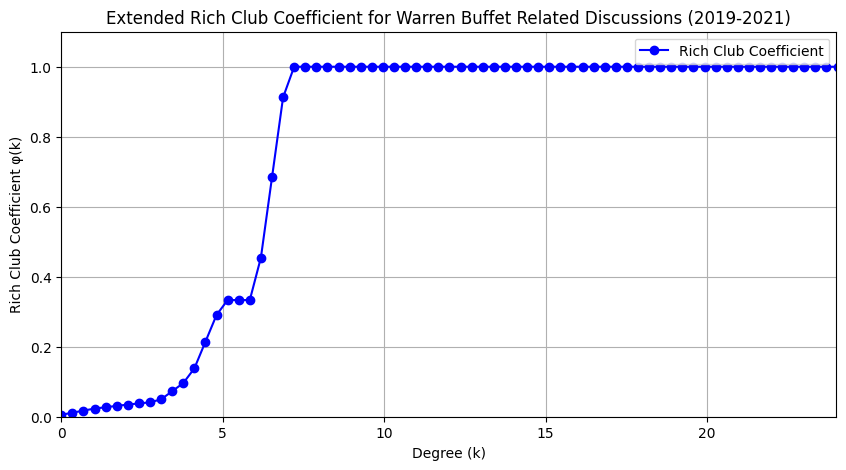

In [26]:
# Function to build a graph
def build_graph(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        user = row["author_comment"]
        reply_to = row["unique_id"]
        G.add_node(user)
        if pd.notna(reply_to):
            G.add_node(reply_to)
            G.add_edge(user, reply_to)
    return G

# Filter dataset for peak years
peak_years = [2019,2020,2021]
filtered_data = merged_data[(rel_comments) & (merged_data["year"].isin(peak_years))]

# Build the graph
G_warren = build_graph(filtered_data)

# Compute rich club coefficient
rich_club = nx.rich_club_coefficient(G_warren, normalized=False)

degrees = list(rich_club.keys())
coefficients = list(rich_club.values())

# Extend the degree range
extended_degrees = np.linspace(min(degrees), max(degrees) + 20, 100)
interpolated_coefficients = np.interp(extended_degrees, degrees, coefficients)

# Plot the rich club coefficient with extended degree scale
plt.figure(figsize=(10, 5))
plt.plot(extended_degrees, interpolated_coefficients, marker="o", linestyle="-", color="b", label="Rich Club Coefficient")
plt.xlim([0, max(degrees) + 10])
plt.ylim([0, max(coefficients) + 0.1])
plt.xlabel("Degree (k)")
plt.ylabel("Rich Club Coefficient φ(k)")
plt.title("Extended Rich Club Coefficient for Warren Buffet Related Discussions (2019-2021)")
plt.legend()
plt.grid(True)
plt.show()

## Sensitivity Analysis

Graph contains 297 nodes and 240 edges


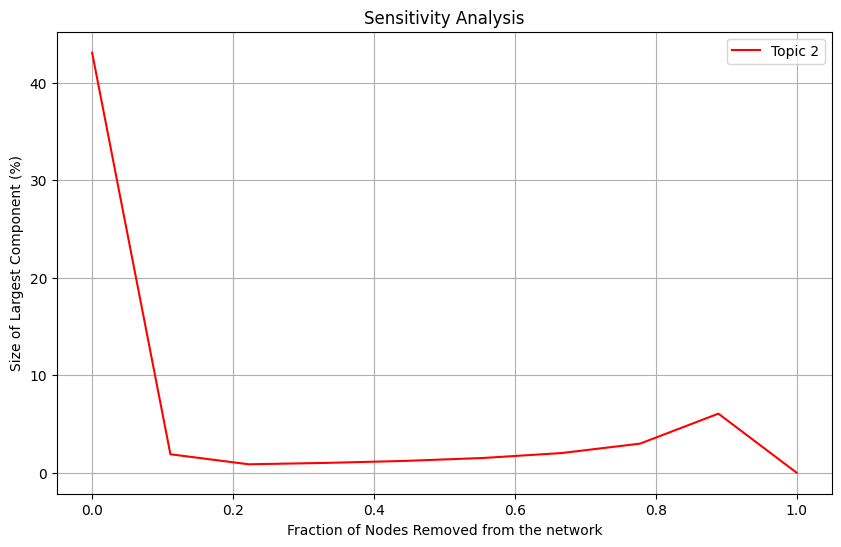

In [27]:
# Function to compute the size of the largest connected component
def largest_component_size(G):
    if len(G.nodes()) == 0:
        return 0
    largest_component = max(nx.connected_components(G), key=len)
    return len(largest_component) / len(G.nodes()) * 100

# Sensitivity analysis function for a specific topic
def sensitivity_analysis_for_topic(data, fraction_steps=10):
    G = nx.Graph()

    # Build the graph for the filtered topic data
    for _, row in filtered_data.iterrows():
        author = row['author_comment']
        parent = row['unique_id']

        if pd.notna(parent) and parent in filtered_data['unique_id'].values:
            G.add_edge(author, parent)

    print(f"Graph contains {len(G.nodes())} nodes and {len(G.edges())} edges")

    # If graph is empty, return empty DataFrame instead of tuple
    if len(G.nodes()) == 0:
        return pd.DataFrame(columns=["Fraction of Nodes Removed", "Largest Component Size (%)"])

    # Prepare for sensitivity analysis
    node_count = len(G.nodes())
    fractions = np.linspace(0, 1, fraction_steps)  # Fraction of nodes to remove
    largest_component_sizes = []

    # Sorted list of nodes based on degree (you can adjust this as needed)
    sorted_nodes = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)

    for fraction in fractions:
        # Number of nodes to remove
        nodes_to_remove = int(fraction * node_count)

        # Remove nodes progressively based on the sorted list
        nodes_removed = sorted_nodes[:nodes_to_remove]
        G.remove_nodes_from(nodes_removed)

        # Compute the size of the largest connected component
        largest_size = largest_component_size(G)
        largest_component_sizes.append(largest_size)

    result_df = pd.DataFrame({
        "Fraction of Nodes Removed": fractions,
        "Largest Component Size (%)": largest_component_sizes
    })

    return result_df

# Perform sensitivity analysis on Topic 2
result_topic = sensitivity_analysis_for_topic(merged_data)

if not result_topic.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(result_topic["Fraction of Nodes Removed"], result_topic["Largest Component Size (%)"], label="Topic 2", color="red")
    plt.xlabel("Fraction of Nodes Removed from the network")
    plt.ylabel("Size of Largest Component (%)")
    plt.title("Sensitivity Analysis")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available for this topic")

In [28]:
# rich_club_df = pd.DataFrame(list(rich_club.items()), columns=['Degree', 'Coefficient'])
# rich_club_df.to_csv("rich_club_coefficient.csv")

## Z-Score

In [29]:
# Calculate Z-score for the 'count' of mentions per year
mean_count = com_count['count'].mean()  # Mean of counts
std_count = com_count['count'].std()  # Standard deviation of counts

# Compute the Z-score for each year
com_count['z_score'] = (com_count['count'] - mean_count) / std_count

# Create an interactive plot using Plotly
fig = go.Figure()

# Add traces for Z-scores vs. count of Warren Buffett mentions
fig.add_trace(go.Scatter(
    x=com_count['count'],
    y=com_count['z_score'],
    mode='markers+lines',
    marker=dict(size=12, color=com_count['z_score'], colorscale='Viridis', showscale=True),
    text=com_count['year'],
    hoverinfo='text+name',
))


fig.update_layout(
    title="Z-Score vs. Count of Topics Related to Warren Buffett",
    xaxis_title="Number of Mentions of Warren Buffett",
    yaxis_title="Z-Score",
    hovermode='closest',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
)

fig.show()

##### The Z-scores reveal how public interest in Warren Buffett fluctuates over time. Years with negative Z-scores (e.g., -0.87) show when mentions were below average, likely during quieter periods in his career. In contrast, positive Z-scores, particularly the peak of 1.94, highlight years of exceptional interest, possibly due to significant events like major investments or public statements. The data suggests that Buffett’s media presence and influence are dynamic, with certain years standing out for higher visibility, while others show a dip in public engagement.

### Monthly Engagement Trends: All Users vs Super Users

In [30]:
merged_data["month"] = merged_data["created_utc_comment"].dt.to_period("M").astype(str)

# Overall Monthly Engagement of All Users
monthly_total_all = merged_data.groupby("month").size().reset_index(name="total_comments")

fig_all = px.line(
    monthly_total_all, x="month", y="total_comments", markers=True,
    title="Overall Engagement Trends of All Users",
    labels={"month": "Month", "total_comments": "Total Comments"},
)

fig_all.update_layout(hovermode="x", xaxis_tickangle=-45)
fig_all.show()

# Monthly Engagement Trends for Super Users
super_user_data = merged_data[merged_data["author_comment"].isin(top_5_users)]

# Aggregate data by month for super users
monthly_total_super = super_user_data.groupby("month").size().reset_index(name="total_comments")

fig_super = px.line(
    monthly_total_super, x="month", y="total_comments", markers=True,
    title="Overall Engagement Trends of Super Users",
    labels={"month": "Month", "total_comments": "Total Comments"},
)

fig_super.update_layout(hovermode="x", xaxis_tickangle=-45)
fig_super.show()

In [31]:
filter_dts=merged_data.copy()

# Filter the data to include only entries after 2020
filter_dts = filter_dts[filter_dts["created_utc_comment"] >= "2020-01-01"]

# Create a new column for the week (using "W-Mon" to make the week start on Monday)
filter_dts["week"] = filter_dts["created_utc_comment"].dt.to_period("W-Mon").astype(str)

# Filter only top 5 super users
super_user_data = filter_dts[filter_dts["author_comment"].isin(top_5_users)]

# Aggregate data by week for super users and all users
weekly_activity_all = filter_dts.groupby(["week", "author_comment"]).size().reset_index(name="comment_count")
weekly_activity_super = super_user_data.groupby(["week", "author_comment"]).size().reset_index(name="comment_count")

# Overall Engagement Trends - Total Comments Per Week for All Users
weekly_total_all = filter_dts.groupby("week").size().reset_index(name="total_comments")

fig2_all = px.line(
    weekly_total_all, x="week", y="total_comments", markers=True,
    title="Overall Engagement Trends of All Users (Weekly After 2020)",
    labels={"week": "Week", "total_comments": "Total Comments"},
)

fig2_all.update_layout(hovermode="x", xaxis_tickangle=-45)
fig2_all.show()

# Overall Engagement Trends - Total Comments Per Week for Super Users
weekly_total_super = super_user_data.groupby("week").size().reset_index(name="total_comments")

fig2_super = px.line(
    weekly_total_super, x="week", y="total_comments", markers=True,
    title="Overall Engagement Trends of Super Users (Weekly After 2020)",
    labels={"week": "Week", "total_comments": "Total Comments"},
)

fig2_super.update_layout(hovermode="x", xaxis_tickangle=-45)
fig2_super.show()

### Analyzing Comments During Specific Time Periods

In [32]:
# Define the two time periods
period_1_start = "2021-01-26"
period_1_end = "2021-02-01"
period_2_start = "2022-01-04"
period_2_end = "2022-01-10"

# Filter for comments within the specified time periods
df_period_1 = merged_data[
    (merged_data["created_utc_comment"] >= period_1_start) &
    (merged_data["created_utc_comment"] <= period_1_end)
]

df_period_2 = merged_data[
    (merged_data["created_utc_comment"] >= period_2_start) &
    (merged_data["created_utc_comment"] <= period_2_end)
]

# Display the number of comments in each period
print(f"Number of comments in {period_1_start} - {period_1_end}: {df_period_1.shape[0]}")
print(f"Number of comments in {period_2_start} - {period_2_end}: {df_period_2.shape[0]}")

Number of comments in 2021-01-26 - 2021-02-01: 174
Number of comments in 2022-01-04 - 2022-01-10: 144


In [33]:
# df_period_1.to_csv("df_period_1.csv")
# df_period_2.to_csv("df_period_2.csv")

In [34]:
df_period_1

id_comment       author_comment unique_id  parent_id  \
8942    gkrqlf6           catgambler    l4nve5  t3_l4nve5   
8943    gks093j     LemonsForLimeaid    l4zalp  t3_l4zalp   
8944    gksm1lg           skyvexkent    l4nve5  t3_l4nve5   
8945    gktmoe0  Ancient-Window-9402    l5e051  t3_l5e051   
8946    gktvio5  Ancient-Window-9402    l5e051  t3_l5e051   
...         ...                  ...       ...        ...   
9111    glj2kqj            [deleted]    l93gui  t3_l93gui   
9112    glj35tn            [deleted]    l9nuwn  t3_l9nuwn   
9113    glj4e06         420-Investor    kxl2yp  t3_kxl2yp   
9114    glj4fl5         420-Investor    kxl2yp  t3_kxl2yp   
9115    gljb3au               Zurevu    l9na7h  t3_l9na7h   

                                                   body created_utc_comment  \
8942                                                boo 2021-01-26 00:28:16   
8943  Who is this guy and why is everyone obsessed w... 2021-01-26 01:53:22   
8944                        Am new here\nWhat's rule #1 2021-01-26 05:17:23   
8945                            The elderly needs this. 2021-01-26 13:51:50   
8946                                       It's running 2021-01-26 15:06:45   
...                                                 ...                 ...   
9111                                          [deleted] 2021-01-31 22:40:06   
9112                                          [deleted] 2021-01-31 22:44:42   
9113  https://www.reddit.com/r/smallcapbets/comments... 2021-01-31 22:54:28   
9114  https://www.reddit.com/r/trakstocks/comments/k... 2021-01-31 22:54:49   
9115  This is not the place to ask for advice for be... 2021-01-31 23:48:35   

      score_comment    link_id  ups  downs  ...    created_utc_post  \
8942              1  t3_l4nve5    2      0  ... 2021-01-25 13:29:54   
8943             -1  t3_l4zalp    2      0  ... 2021-01-25 22:26:09   
8944              1  t3_l4nve5    2      0  ... 2021-01-25 13:29:54   
8945              1  t3_l5e051    2      0  ... 2021-01-26 13:30:01   
8946              1  t3_l5e051    2      0  ... 2021-01-26 13:30:01   
...             ...        ...  ...    ...  ...                 ...   
9111              1  t3_l93gui    2      0  ... 2021-01-31 03:32:09   
9112              2  t3_l9nuwn    2      0  ... 2021-01-31 22:31:45   
9113              1  t3_kxl2yp    2      0  ... 2021-01-15 02:37:12   
9114              1  t3_kxl2yp    2      0  ... 2021-01-15 02:37:12   
9115              1  t3_l9na7h    2      0  ... 2021-01-31 22:04:37   

     score_post num_comments  \
8942         11            3   
8943         13            4   
8944         11            3   
8945          1            3   
8946          1            3   
...         ...          ...   
9111         81           47   
9112          0            8   
9113          5            3   
9114          5            3   
9115          1            1   

                                                   text  \
8942                   Stock to Watch Jan 25th 2021 boo   
8943  Chamath Palihapitiya Leads PIPE Rounds For Lat...   
8944  Stock to Watch Jan 25th 2021 Am new here\nWhat...   
8945             Next GameStop! The elderly needs this.   
8946                        Next GameStop! It's running   
...                                                 ...   
9111  GME Institutional Ownership. If It doesn't dro...   
9112   Will Silver Rally Today 👇 Poll Below 👇 [deleted]   
9113  BUY: XLY(auxly cannabis) https://www.reddit.co...   
9114  BUY: XLY(auxly cannabis) https://www.reddit.co...   
9115  Revolut to invest in stocks and crypto This is...   

                                           cleaned_text  topic topic_label  \
8942                      stock watch jan 25th 2021 boo      6         NaN   
8943  chamath palihapitiya lead pipe round latch sun...      9         NaN   
8944            stock watch jan 25th 2021 new \n rule 1      6         NaN   
8945                              gamestop elderly need      1  

In [35]:
df_period_2

id_comment author_comment unique_id  parent_id  \
12117    hr7k971         Zurevu    rvs1w5  t3_rvs1w5   
12118    hr8a0tp      [deleted]    rb3vfv  t3_rb3vfv   
12119    hr8bhpt      [deleted]    qlv3ks  t3_qlv3ks   
12120    hr8bioq      [deleted]    qtqe6d  t3_qtqe6d   
12121    hr8bjgk      [deleted]    ruj0ll  t3_ruj0ll   
...          ...            ...       ...        ...   
12256    hrshxkw      [deleted]    rnq998  t3_rnq998   
12257    hrthvta         Zurevu    rz8e25  t3_rz8e25   
12258    hrvzdk3      [deleted]    rzm1t3  t3_rzm1t3   
12259    hrycfz8   Ibelieveyou2    rzpcl1  t3_rzpcl1   
12260    hryp4xa         Zurevu    s00j9l  t3_s00j9l   

                                                    body created_utc_comment  \
12117  Your post was removed because it is about cryp... 2022-01-04 13:19:54   
12118                                          [removed] 2022-01-04 16:28:53   
12119                                          [removed] 2022-01-04 16:38:36   
12120                                          [removed] 2022-01-04 16:38:47   
12121                                          [removed] 2022-01-04 16:38:56   
...                                                  ...                 ...   
12256                                          [removed] 2022-01-08 16:17:27   
12257  Your post/comment has been removed because it ... 2022-01-08 20:13:00   
12258                                          [deleted] 2022-01-09 07:32:10   
12259                             What's the trade then? 2022-01-09 19:32:20   
12260  Your post was removed for pertaining to person... 2022-01-09 20:47:00   

       score_comment    link_id  ups  downs  ...    created_utc_post  \
12117              1  t3_rvs1w5    2      0  ... 2022-01-04 11:16:27   
12118              1  t3_rb3vfv    2      0  ... 2021-12-07 17:28:55   
12119              1  t3_qlv3ks    2      0  ... 2021-11-03 14:00:17   
12120              1  t3_qtqe6d    2      0  ... 2021-11-14 14:00:14   
12121              1  t3_ruj0ll    2      0  ... 2022-01-02 20:48:10   
...              ...        ...  ...    ...  ...                 ...   
12256              1  t3_rnq998    2      0  ... 2021-12-24 17:00:48   
12257              1  t3_rz8e25    2      0  ... 2022-01-08 19:55:42   
12258              2  t3_rzm1t3    2      0  ... 2022-01-09 07:14:52   
12259              1  t3_rzpcl1    2      0  ... 2022-01-09 11:03:44   
12260              1  t3_s00j9l    2      0  ... 2022-01-09 20:21:09   

      score_post num_comments  \
12117          0            1   
12118          9           16   
12119         27           31   
12120         13           13   
12121          9            4   
...          ...          ...   
12256         15           12   
12257          2            1   
12258          0            0   
12259          2            1   
12260          1            1   

                                                    text  \
12117  Top 5 Best Investment Plans - 2022 Your post w...   
12118          Major investment trends in 2022 [removed]   
12119  r/InvestmentClub's Portfolio Dashboard Is Now ...   
12120  Links to all stock pitches before the investme...   
12121      Which of these 3 ETFs is redundant? [removed]   
...                                                  ...   
12256  Warren Buffett: Investment Advice For Beginner...   
12257  Need help with Investing Your post/comment has...   
12258  Hey folks, hope you are doing great. So, we ar...   
12259  Sundial Growers inc (SNDL) takes over on Alcan...   
12260  What do rich people do better than the rest of...   

                                            cleaned_text  topic topic_label  \
12117  5 investment plan 2022 post remove cryptocurre...      9         NaN   
12118                 major investment trend 2022 remove      6         NaN   
12119   investmentclub portfolio dashboard online remove      7         NaN   
12120     link stock pitch investment club revive remove      5         N